In [11]:
import torch
import numpy as np
import os
import pickle
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Path to processed data
data_path = "/kaggle/working/processed_mimic_data/"

class ProcessedMIMICDataset(Dataset):
    def __init__(self, data_path, data_format='pt'):
        """
        Load a processed MIMIC dataset
        
        Args:
            data_path: Path to the processed data directory
            data_format: Format to load ('pt' for PyTorch tensors, 'npy' for NumPy, 'pkl' for Pickle)
        """
        self.data_path = data_path
        self.data_format = data_format
        
        if data_format == 'pkl':
            # Load the pickle file
            with open(os.path.join(data_path, "all_data.pkl"), 'rb') as f:
                self.all_data = pickle.load(f)
            
            self.embeddings = self.all_data['embeddings']
            self.labels = self.all_data['labels']
            self.subject_ids = self.all_data['subject_ids']
            self.study_ids = self.all_data['study_ids']
            self.demographics = self.all_data['demographics']
            
        elif data_format == 'pt':
            # Load PyTorch tensors with weights_only=True to avoid security warnings
            self.embeddings = torch.load(os.path.join(data_path, "embeddings.pt"), weights_only=True)
            self.labels = torch.load(os.path.join(data_path, "labels.pt"), weights_only=True)
            
            # Load IDs from CSV
            ids_df = pd.read_csv(os.path.join(data_path, "ids.csv"))
            self.subject_ids = ids_df['subject_id'].tolist()
            self.study_ids = ids_df['study_id'].tolist()
            
            # Load demographics
            with open(os.path.join(data_path, "demographics.pkl"), 'rb') as f:
                self.demographics = pickle.load(f)
                
        elif data_format == 'npy':
            # Load NumPy arrays
            self.embeddings = np.load(os.path.join(data_path, "embeddings.npy"))
            self.labels = np.load(os.path.join(data_path, "labels.npy"))
            
            # Load IDs from CSV
            ids_df = pd.read_csv(os.path.join(data_path, "ids.csv"))
            self.subject_ids = ids_df['subject_id'].tolist()
            self.study_ids = ids_df['study_id'].tolist()
            
            # Load demographics
            with open(os.path.join(data_path, "demographics.pkl"), 'rb') as f:
                self.demographics = pickle.load(f)
                
        else:
            raise ValueError(f"Unsupported data format: {data_format}")
        
        print(f"Loaded dataset from {data_path} with {len(self.embeddings)} samples")
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        if self.data_format == 'pt':
            embedding = self.embeddings[idx]
            labels = self.labels[idx]
        else:
            embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
            labels = torch.tensor(self.labels[idx], dtype=torch.float32)
            
        return {
            'embedding': embedding,
            'labels': labels,
            'subject_id': self.subject_ids[idx],
            'study_id': self.study_ids[idx],
            'demographics': self.demographics[idx]
        }

# Load the datasets
train_dataset = ProcessedMIMICDataset(os.path.join(data_path, "train"), data_format='pt')
test_dataset = ProcessedMIMICDataset(os.path.join(data_path, "test"), data_format='pt')

# Create validation set from train (if needed)
def create_train_val_split(train_dataset, val_ratio=0.1, random_seed=42):
    """Split training dataset into train and validation sets"""
    dataset_size = len(train_dataset)
    val_size = int(val_ratio * dataset_size)
    train_size = dataset_size - val_size
    
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(random_seed)
    )
    
    print(f"Split train dataset: {train_size} training samples, {val_size} validation samples")
    
    return train_subset, val_subset

# Create train/val split (optional)
train_subset, val_subset = create_train_val_split(train_dataset)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Display dataset statistics
print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(test_dataset)}")

# Example of accessing a batch
sample_batch = next(iter(train_loader))
print(f"Sample batch shapes:")
print(f"  Embeddings: {sample_batch['embedding'].shape}")
print(f"  Labels: {sample_batch['labels'].shape}")

Loaded dataset from /kaggle/working/processed_mimic_data/train with 207314 samples
Loaded dataset from /kaggle/working/processed_mimic_data/test with 21591 samples
Split train dataset: 186583 training samples, 20731 validation samples
Training samples: 186583
Validation samples: 20731
Test samples: 21591
Sample batch shapes:
  Embeddings: torch.Size([128, 1376])
  Labels: torch.Size([128, 14])


Input dimension: 1376
Output dimension: 14
Using device: cuda


Epoch 1/20 [Val]: 100%|██████████| 162/162 [00:00<00:00, 375.13it/s]



Per-class AUC:
  Enlarged Cardiomediastinum: 0.6883
  Cardiomegaly: 0.7961
  Lung Opacity: 0.7502
  Lung Lesion: 0.7722
  Edema: 0.8871
  Consolidation: 0.7962
  Pneumonia: 0.7378
  Atelectasis: 0.7962
  Pneumothorax: 0.8884
  Pleural Effusion: 0.8971
  Pleural Other: 0.8217
  Fracture: 0.6945
  Support Devices: 0.9256
  No Finding: 0.8546
Epoch 1/20 - Train Loss: 0.2940, Val Loss: 0.2549, Val AUC: 0.8076, Time: 8.17s


Epoch 2/20 [Val]: 100%|██████████| 162/162 [00:00<00:00, 353.45it/s]



Per-class AUC:
  Enlarged Cardiomediastinum: 0.6928
  Cardiomegaly: 0.7985
  Lung Opacity: 0.7521
  Lung Lesion: 0.7807
  Edema: 0.8888
  Consolidation: 0.8043
  Pneumonia: 0.7418
  Atelectasis: 0.7999
  Pneumothorax: 0.8933
  Pleural Effusion: 0.8970
  Pleural Other: 0.8320
  Fracture: 0.7138
  Support Devices: 0.9273
  No Finding: 0.8553
Epoch 2/20 - Train Loss: 0.2595, Val Loss: 0.2539, Val AUC: 0.8127, Time: 8.17s


Epoch 3/20 [Val]: 100%|██████████| 162/162 [00:00<00:00, 342.11it/s]



Per-class AUC:
  Enlarged Cardiomediastinum: 0.6902
  Cardiomegaly: 0.7969
  Lung Opacity: 0.7508
  Lung Lesion: 0.7821
  Edema: 0.8821
  Consolidation: 0.8017
  Pneumonia: 0.7398
  Atelectasis: 0.8003
  Pneumothorax: 0.8928
  Pleural Effusion: 0.8938
  Pleural Other: 0.8321
  Fracture: 0.7300
  Support Devices: 0.9269
  No Finding: 0.8528
Epoch 3/20 - Train Loss: 0.2578, Val Loss: 0.2594, Val AUC: 0.8123, Time: 8.40s


Epoch 4/20 [Val]: 100%|██████████| 162/162 [00:00<00:00, 355.25it/s]



Per-class AUC:
  Enlarged Cardiomediastinum: 0.6871
  Cardiomegaly: 0.8004
  Lung Opacity: 0.7518
  Lung Lesion: 0.7878
  Edema: 0.8890
  Consolidation: 0.8069
  Pneumonia: 0.7424
  Atelectasis: 0.8010
  Pneumothorax: 0.8957
  Pleural Effusion: 0.8976
  Pleural Other: 0.8403
  Fracture: 0.7258
  Support Devices: 0.9276
  No Finding: 0.8570
Epoch 4/20 - Train Loss: 0.2573, Val Loss: 0.2530, Val AUC: 0.8150, Time: 8.44s


Epoch 5/20 [Val]: 100%|██████████| 162/162 [00:00<00:00, 339.93it/s]



Per-class AUC:
  Enlarged Cardiomediastinum: 0.6958
  Cardiomegaly: 0.8036
  Lung Opacity: 0.7523
  Lung Lesion: 0.7848
  Edema: 0.8910
  Consolidation: 0.8028
  Pneumonia: 0.7387
  Atelectasis: 0.8018
  Pneumothorax: 0.8961
  Pleural Effusion: 0.8994
  Pleural Other: 0.8687
  Fracture: 0.7376
  Support Devices: 0.9284
  No Finding: 0.8577
Epoch 5/20 - Train Loss: 0.2569, Val Loss: 0.2526, Val AUC: 0.8185, Time: 8.59s


Epoch 6/20 [Val]: 100%|██████████| 162/162 [00:00<00:00, 368.75it/s]



Per-class AUC:
  Enlarged Cardiomediastinum: 0.7002
  Cardiomegaly: 0.8034
  Lung Opacity: 0.7544
  Lung Lesion: 0.7908
  Edema: 0.8896
  Consolidation: 0.8043
  Pneumonia: 0.7448
  Atelectasis: 0.8028
  Pneumothorax: 0.8991
  Pleural Effusion: 0.8989
  Pleural Other: 0.8670
  Fracture: 0.7414
  Support Devices: 0.9289
  No Finding: 0.8584
Epoch 6/20 - Train Loss: 0.2563, Val Loss: 0.2516, Val AUC: 0.8203, Time: 8.58s


Epoch 7/20 [Val]: 100%|██████████| 162/162 [00:00<00:00, 339.01it/s]



Per-class AUC:
  Enlarged Cardiomediastinum: 0.6972
  Cardiomegaly: 0.8040
  Lung Opacity: 0.7553
  Lung Lesion: 0.7915
  Edema: 0.8899
  Consolidation: 0.8078
  Pneumonia: 0.7471
  Atelectasis: 0.8025
  Pneumothorax: 0.9000
  Pleural Effusion: 0.8993
  Pleural Other: 0.8544
  Fracture: 0.7501
  Support Devices: 0.9277
  No Finding: 0.8584
Epoch 7/20 - Train Loss: 0.2559, Val Loss: 0.2518, Val AUC: 0.8204, Time: 8.55s


Epoch 8/20 [Val]: 100%|██████████| 162/162 [00:00<00:00, 329.38it/s]



Per-class AUC:
  Enlarged Cardiomediastinum: 0.6951
  Cardiomegaly: 0.7990
  Lung Opacity: 0.7525
  Lung Lesion: 0.7908
  Edema: 0.8876
  Consolidation: 0.8063
  Pneumonia: 0.7457
  Atelectasis: 0.8009
  Pneumothorax: 0.8982
  Pleural Effusion: 0.8982
  Pleural Other: 0.8548
  Fracture: 0.7490
  Support Devices: 0.9282
  No Finding: 0.8558
Epoch 8/20 - Train Loss: 0.2557, Val Loss: 0.2536, Val AUC: 0.8187, Time: 8.61s


Epoch 9/20 [Val]: 100%|██████████| 162/162 [00:00<00:00, 335.79it/s]



Per-class AUC:
  Enlarged Cardiomediastinum: 0.6968
  Cardiomegaly: 0.8010
  Lung Opacity: 0.7516
  Lung Lesion: 0.7876
  Edema: 0.8898
  Consolidation: 0.8066
  Pneumonia: 0.7448
  Atelectasis: 0.8028
  Pneumothorax: 0.8988
  Pleural Effusion: 0.8982
  Pleural Other: 0.8434
  Fracture: 0.7404
  Support Devices: 0.9286
  No Finding: 0.8568
Epoch 9/20 - Train Loss: 0.2558, Val Loss: 0.2527, Val AUC: 0.8177, Time: 8.56s


Epoch 10/20 [Val]: 100%|██████████| 162/162 [00:00<00:00, 337.74it/s]



Per-class AUC:
  Enlarged Cardiomediastinum: 0.6976
  Cardiomegaly: 0.8054
  Lung Opacity: 0.7540
  Lung Lesion: 0.7905
  Edema: 0.8898
  Consolidation: 0.8063
  Pneumonia: 0.7471
  Atelectasis: 0.8037
  Pneumothorax: 0.8998
  Pleural Effusion: 0.8986
  Pleural Other: 0.8655
  Fracture: 0.7453
  Support Devices: 0.9283
  No Finding: 0.8577
Epoch 10/20 - Train Loss: 0.2557, Val Loss: 0.2519, Val AUC: 0.8207, Time: 8.55s


Epoch 11/20 [Val]: 100%|██████████| 162/162 [00:00<00:00, 370.66it/s]



Per-class AUC:
  Enlarged Cardiomediastinum: 0.7043
  Cardiomegaly: 0.8061
  Lung Opacity: 0.7545
  Lung Lesion: 0.7930
  Edema: 0.8904
  Consolidation: 0.8083
  Pneumonia: 0.7442
  Atelectasis: 0.8045
  Pneumothorax: 0.8957
  Pleural Effusion: 0.8988
  Pleural Other: 0.8725
  Fracture: 0.7403
  Support Devices: 0.9288
  No Finding: 0.8585
Epoch 11/20 - Train Loss: 0.2553, Val Loss: 0.2520, Val AUC: 0.8214, Time: 8.23s
Early stopping triggered after 11 epochs


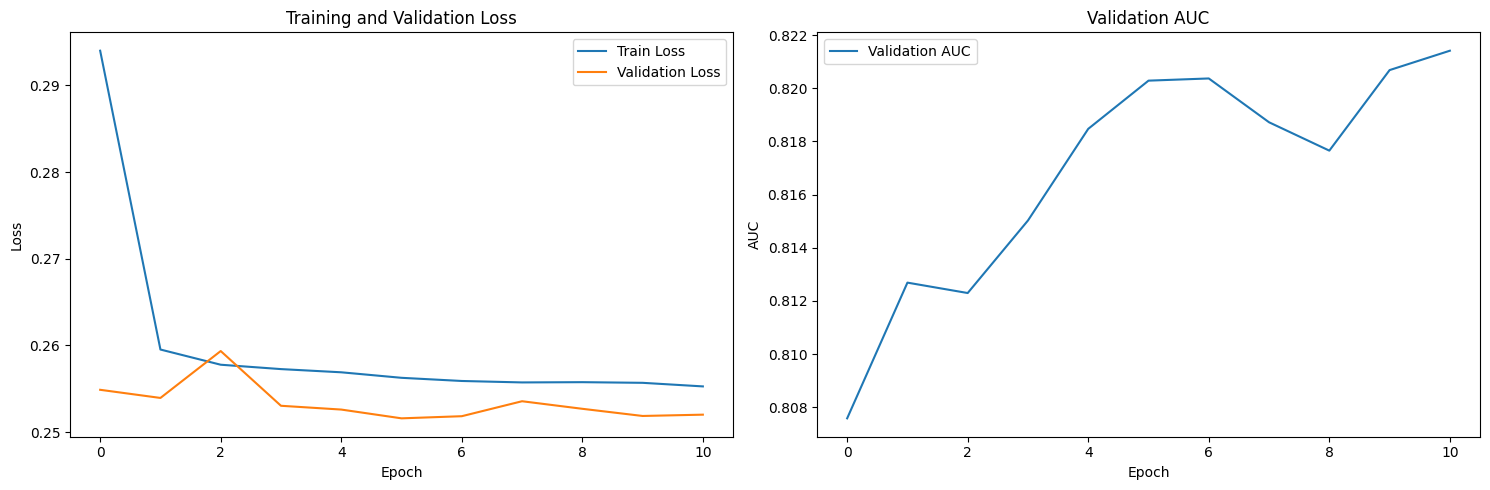

Evaluating on test set: 100%|██████████| 169/169 [00:00<00:00, 348.63it/s]



Per-class AUC:
  Enlarged Cardiomediastinum: 0.7122
  Cardiomegaly: 0.8027
  Lung Opacity: 0.7680
  Lung Lesion: 0.7876
  Edema: 0.8923
  Consolidation: 0.8255
  Pneumonia: 0.7380
  Atelectasis: 0.8065
  Pneumothorax: 0.8743
  Pleural Effusion: 0.9074
  Pleural Other: 0.8535
  Fracture: 0.7510
  Support Devices: 0.9285
  No Finding: 0.8667

Test Loss: 0.2490, Test AUC: 0.8224
Saving predictions to test_predictions.csv...
Created prediction DataFrame with 21591 rows
Loading external demographics from:
  - /kaggle/input/mimic-patients/patients.csv
  - /kaggle/input/mimic-patients/admissions.csv
Loaded patients data: 382278 rows, 6 columns
Loaded admissions data: 523740 rows, 15 columns
After merging with patients: 21591 rows, 35 columns
Using most recent admission for each patient: 256878 rows
After merging with admissions: 21591 rows, 49 columns

Missing values in demographic columns:
  - ethnicity: 0 missing (0.0%)
  - dod: 17801 missing (82.4%)
  - insurance: 0 missing (0.0%)
  - hos

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import time
from tqdm import tqdm
import os

# Define the neural network model
class MIMICClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.2):
        """
        Simple feed-forward neural network for multi-label classification
        
        Args:
            input_dim: Dimension of input embeddings
            hidden_dims: List of hidden layer dimensions
            output_dim: Number of output classes
            dropout_rate: Dropout probability for regularization
        """
        super(MIMICClassifier, self).__init__()
        
        # Create the layers
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.Dropout(dropout_rate))
        
        # Hidden layers
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
        # No activation function here since we're using BCEWithLogitsLoss
        # which combines sigmoid and binary cross entropy
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                device, num_epochs=10, patience=3, label_columns=None):
    """
    Train the model and evaluate on validation set
    
    Args:
        model: Neural network model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer
        device: Device to use (cuda/cpu)
        num_epochs: Maximum number of epochs to train
        patience: Early stopping patience
        label_columns: List of label column names for AUC reporting
        
    Returns:
        Trained model and history of metrics
    """
    model.to(device)
    
    # For tracking metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_auc': []
    }
    
    # For early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            # Get the inputs and labels
            inputs = batch['embedding'].to(device)
            labels = batch['labels'].to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        # Calculate average training loss
        train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_outputs = []
        all_labels = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs = batch['embedding'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                
                # Save predictions and true labels for AUC calculation
                all_outputs.append(torch.sigmoid(outputs).cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        
        # Calculate validation metrics
        val_loss = val_loss / len(val_loader.dataset)
        history['val_loss'].append(val_loss)
        
        # Calculate AUC for each class
        all_outputs = np.vstack(all_outputs)
        all_labels = np.vstack(all_labels)
        
        # Calculate average AUC across all classes
        try:
            # Handle potential cases where a class might have all same labels
            aucs = []
            for i in range(all_labels.shape[1]):
                if len(np.unique(all_labels[:, i])) > 1:  # Only calculate AUC if we have both classes
                    aucs.append(roc_auc_score(all_labels[:, i], all_outputs[:, i]))
            
            val_auc = np.mean(aucs)
            history['val_auc'].append(val_auc)
            
            # Print per-class AUCs if label names are provided
            if label_columns is not None:
                print("\nPer-class AUC:")
                for i, label in enumerate(label_columns):
                    if i < len(aucs):
                        print(f"  {label}: {aucs[i]:.4f}")
        except Exception as e:
            print(f"Error calculating AUC: {e}")
            val_auc = 0
            history['val_auc'].append(val_auc)
        
        # Calculate epoch duration
        epoch_duration = time.time() - start_time
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val AUC: {val_auc:.4f}, "
              f"Time: {epoch_duration:.2f}s")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                model.load_state_dict(best_model)
                break
    
    # Load best model
    if 'best_model' in locals():
        model.load_state_dict(best_model)
    
    return model, history

# Function to evaluate the model on the test set
def evaluate_model(model, test_loader, criterion, device, label_columns=None, save_predictions=True):
    """
    Evaluate the model on the test set and merge with external demographic data
    
    Args:
        model: Trained neural network model
        test_loader: DataLoader for test data
        criterion: Loss function
        device: Device to use (cuda/cpu)
        label_columns: List of label column names for AUC reporting
        save_predictions: Whether to save predictions to CSV
        
    Returns:
        Test loss and AUC
    """
    model.eval()
    test_loss = 0.0
    all_outputs = []
    all_labels = []
    all_subject_ids = []
    all_study_ids = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating on test set"):
            inputs = batch['embedding'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            
            # Save predictions and true labels for AUC calculation
            all_outputs.append(torch.sigmoid(outputs).cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            
            # Save IDs for CSV output
            all_subject_ids.extend(batch['subject_id'])
            all_study_ids.extend(batch['study_id'])
    
    # Calculate test loss
    test_loss = test_loss / len(test_loader.dataset)
    
    # Calculate AUC for each class
    all_outputs = np.vstack(all_outputs)
    all_labels = np.vstack(all_labels)
    
    # Calculate average AUC across all classes
    try:
        aucs = []
        for i in range(all_labels.shape[1]):
            if len(np.unique(all_labels[:, i])) > 1:  # Only calculate AUC if we have both classes
                aucs.append(roc_auc_score(all_labels[:, i], all_outputs[:, i]))
        
        test_auc = np.mean(aucs)
        
        # Print per-class AUCs if label names are provided
        if label_columns is not None:
            print("\nPer-class AUC:")
            class_metrics = {}
            for i, label in enumerate(label_columns):
                if i < len(aucs):
                    print(f"  {label}: {aucs[i]:.4f}")
                    class_metrics[label] = aucs[i]
    except Exception as e:
        print(f"Error calculating AUC: {e}")
        test_auc = 0
        class_metrics = {}
    
    print(f"\nTest Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}")
    
    # Save predictions to CSV if requested
    if save_predictions and label_columns is not None:
        save_predictions_with_demographics(
            all_subject_ids, 
            all_study_ids, 
            all_outputs, 
            all_labels, 
            label_columns
        )
    
    return test_loss, test_auc, class_metrics

def save_predictions_with_demographics(subject_ids, study_ids, predictions, ground_truth, label_columns, filename="test_predictions.csv"):
    """
    Save test predictions to a CSV file and merge with external demographics data
    
    Args:
        subject_ids: List of subject IDs
        study_ids: List of study IDs
        predictions: Numpy array of predicted probabilities
        ground_truth: Numpy array of ground truth labels
        label_columns: List of label column names
        filename: Output filename
    """
    print(f"Saving predictions to {filename}...")
    
    # Create pandas DataFrame with IDs and predictions
    data = {
        'subject_id': subject_ids,
        'study_id': study_ids
    }
    
    # Add ground truth columns
    for i, col in enumerate(label_columns):
        data[f'{col}_ground_truth'] = ground_truth[:, i]
    
    # Add prediction probability columns
    for i, col in enumerate(label_columns):
        data[f'{col}_probability'] = predictions[:, i]
    
    # Convert to DataFrame 
    df = pd.DataFrame(data)
    
    print(f"Created prediction DataFrame with {len(df)} rows")
    
    # Load external demographic files
    try:
        patients_file = "/kaggle/input/mimic-patients/patients.csv"
        admissions_file = "/kaggle/input/mimic-patients/admissions.csv"
        
        print(f"Loading external demographics from:")
        print(f"  - {patients_file}")
        print(f"  - {admissions_file}")
        
        patients_df = pd.read_csv(patients_file)
        admissions_df = pd.read_csv(admissions_file)
        
        # Print a summary of the loaded data
        print(f"Loaded patients data: {patients_df.shape[0]} rows, {patients_df.shape[1]} columns")
        print(f"Loaded admissions data: {admissions_df.shape[0]} rows, {admissions_df.shape[1]} columns")
        
        # Make sure subject_id is the same data type in both dataframes
        patients_df['subject_id'] = patients_df['subject_id'].astype(str)
        admissions_df['subject_id'] = admissions_df['subject_id'].astype(str)
        df['subject_id'] = df['subject_id'].astype(str)
        
        # Merge with patients data
        merged_df = df.merge(patients_df, on='subject_id', how='left')
        print(f"After merging with patients: {merged_df.shape[0]} rows, {merged_df.shape[1]} columns")
        
        # For admissions, we might have multiple admissions per patient
        # Strategy: Take the most recent admission for each subject
        if 'admittime' in admissions_df.columns:
            admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
            latest_admissions = admissions_df.sort_values('admittime').groupby('subject_id').last().reset_index()
            print(f"Using most recent admission for each patient: {latest_admissions.shape[0]} rows")
            merged_df = merged_df.merge(latest_admissions, on='subject_id', how='left')
        else:
            # If no timestamp, just merge and note potential duplicates
            print("Warning: No admission time found, merging all admissions (may cause duplicates)")
            merged_df = merged_df.merge(admissions_df, on='subject_id', how='left')
        
        print(f"After merging with admissions: {merged_df.shape[0]} rows, {merged_df.shape[1]} columns")
        
        # Check for any duplicate rows that might have been created by the merge
        if merged_df.shape[0] > df.shape[0]:
            print(f"Warning: Merge created {merged_df.shape[0] - df.shape[0]} duplicate rows")
            print("Taking first occurrence for each subject_id/study_id pair")
            merged_df = merged_df.drop_duplicates(subset=['subject_id', 'study_id'], keep='first')
            print(f"After removing duplicates: {merged_df.shape[0]} rows")
        
        # Count missing values for demographic columns
        demo_cols = list(set(merged_df.columns) - set(df.columns))
        missing_counts = merged_df[demo_cols].isnull().sum()
        print("\nMissing values in demographic columns:")
        for col, count in missing_counts.items():
            pct = count / len(merged_df) * 100
            print(f"  - {col}: {count} missing ({pct:.1f}%)")
        
        # Save the enhanced dataframe
        merged_df.to_csv(filename, index=False)
        print(f"Saved enhanced predictions with demographics to {filename}")
        
        # Print column structure for reference
        print("\nCSV column structure:")
        column_groups = {
            "Identifiers": [col for col in merged_df.columns if "id" in col.lower()],
            "Demographics": demo_cols,
            "Ground Truth": [col for col in merged_df.columns if col.endswith("_ground_truth")],
            "Predictions": [col for col in merged_df.columns if col.endswith("_probability")]
        }
        
        for group, cols in column_groups.items():
            print(f"\n{group} ({len(cols)} columns):")
            for col in cols[:10]:  # Show only first 10 columns if there are many
                print(f"  - {col}")
            if len(cols) > 10:
                print(f"  ... and {len(cols) - 10} more columns")
        
        # Return the final dataframe for further analysis if needed
        return merged_df
        
    except Exception as e:
        print(f"Error merging demographic data: {e}")
        print("Saving original predictions without demographics")
        df.to_csv(filename, index=False)
        return df

# Function to plot the training history
def plot_training_history(history):
    """
    Plot the training and validation metrics
    
    Args:
        history: Dictionary containing training history
    """
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot AUC
    plt.subplot(1, 2, 2)
    plt.plot(history['val_auc'], label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Validation AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Main execution code
if __name__ == "__main__":
    # Get a sample batch to determine input dimensions
    sample_batch = next(iter(train_loader))
    input_dim = sample_batch['embedding'].shape[1]
    output_dim = sample_batch['labels'].shape[1]
    
    print(f"Input dimension: {input_dim}")
    print(f"Output dimension: {output_dim}")
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Model hyperparameters
    hidden_dims = [512, 256, 128]
    dropout_rate = 0.3
    learning_rate = 0.001
    weight_decay = 1e-5
    num_epochs = 20
    patience = 5
    
    # Initialize model
    model = MIMICClassifier(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        output_dim=output_dim,
        dropout_rate=dropout_rate
    )
    
    # Define loss function and optimizer
    # Using BCEWithLogitsLoss for multi-label classification
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Train the model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        patience=patience,
        label_columns=label_columns
    )
    
    # Plot training history
    plot_training_history(history)
    
    # Evaluate on test set
    test_loss, test_auc, class_metrics = evaluate_model(
        model=trained_model,
        test_loader=test_loader,
        criterion=criterion,
        device=device,
        label_columns=label_columns,
        save_predictions=True
    )
    
    # Save the model
    torch.save(trained_model.state_dict(), "mimic_classifier_model.pt")
    print("Model saved to mimic_classifier_model.pt")